crypto factor model using deep neural nets
features: open, high, low, close, count, volume, rolling volatility, volume moving average, stddev of the close
predicts: close for time t + 1 with the features for t

In [2]:
#imports
from coins import Coin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizer_v2 as opt

In [17]:
#get data
coin = Coin('XXBTZUSD', interval='1440')
window = 10
nan = [None for _ in range(window)]
coin.tdata['percent_return'] = (coin.data.close-coin.data.close.shift(1))/coin.data.close.shift(1)
sma_volume = nan + [np.mean(coin.data.volume[i:i+window]) for i in range(len(coin.data.volume)-window)]
rolling_stddev = nan + [np.std(coin.data.close[i:i+window]) for i in range(len(coin.data.close)-window)]
rolling_volatility = nan + [None] + [np.std(coin.logrs[i:i+window]) for i in range(len(coin.logrs)-window)]
macd = nan + [np.mean(coin.data.close[i:i+window]) - np.mean(coin.data.close[i:i+int(window/2)]) for i in range(len(coin.data.close)-window)]
data = pd.concat([coin.tdata.drop(['time'],axis=1), pd.DataFrame({'sma_volume':sma_volume, 'rolling_stddev':rolling_stddev, 'rolling_volatility':rolling_volatility, 'macd':macd})], axis=1)
features = data.iloc[window+1:-1,:].reset_index(drop=True)
features

,open,high,low,close,vwap,volume,count,percent_return,sma_volume,rolling_stddev,rolling_volatility,macd
0,9265.8,9545.0,9234.0,9460.0,9422.9,4753.441604,18475,0.020959,6640.385984,168.139408,0.030107,20.42
1,9459.9,9492.8,9353.8,9471.0,9421.0,1910.814282,7882,0.001163,5619.334381,174.947295,0.023788,-32.58
2,9472.9,9475.0,9230.6,9330.4,9361.6,2680.386802,9347,-0.014845,5372.076279,184.697209,0.023270,-75.25
3,9328.4,9499.9,8905.0,9425.3,9216.4,9823.894283,31566,0.010171,4958.282145,200.205112,0.022969,-118.67
4,9425.3,9593.0,9385.0,9528.5,9494.5,5563.380482,19545,0.010949,5428.570904,206.959543,0.022911,-192.85
...,...,...,...,...,...,...,...,...,...,...,...,...
703,31294.5,31294.5,29060.0,29826.1,29942.1,3703.174505,28913,-0.046995,6527.085409,2547.816589,0.047857,-1807.48
704,29826.1,30742.0,29403.0,30408.3,30156.8,2810.860740,23704,0.019520,6607.646580,2087.606581,0.048840,-1021.95
705,30408.4,30653.1,28589.1,28664.3,29263.7,4177.515331,26075,-0.057353,6759.401610,1426.168024,0.050179,-223.50
706,28657.6,30503.7,28649.2,30280.7,29656.1,3722.853347,25266,0.056391,6805.428038,846.885705,0.051360,200.83


In [18]:
#preprocessing
labels = coin.tdata.close[window+2:].reset_index(drop=True)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2)
ct = ColumnTransformer([('only numeric', StandardScaler(), features.columns)], remainder='passthrough')
features_train = ct.fit_transform(features_train)
features_test = ct.fit_transform(features_test)

In [39]:
#model creation
def return_model():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(features.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, name='Output'))
    model.compile(loss='mse', optimizer=opt.adam.Adam(learning_rate=0.00001), metrics=['mape','mae'])
    model.summary()
    return model
model = return_model()
    

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 512)               6656      
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 256)               131328    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_65 (Dense)            (None, 256)               65792     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_66 (Dense)            (None, 128)              

In [40]:
#training
es = EarlyStopping(monitor='val_loss', mode='min', patience=100)
history = model.fit(features_train, labels_train, epochs=5000, batch_size=20, validation_split=.175, verbose=2, callbacks=[es])

Epoch 1/5000
24/24 - 3s - loss: 1585374336.0000 - mape: 99.9999 - mae: 36008.7070 - val_loss: 1590478592.0000 - val_mape: 99.9998 - val_mae: 36367.5430 - 3s/epoch - 126ms/step
Epoch 2/5000
24/24 - 0s - loss: 1585371008.0000 - mape: 99.9997 - mae: 36008.6641 - val_loss: 1590475520.0000 - val_mape: 99.9996 - val_mae: 36367.4961 - 257ms/epoch - 11ms/step
Epoch 3/5000
24/24 - 0s - loss: 1585367424.0000 - mape: 99.9994 - mae: 36008.6172 - val_loss: 1590471552.0000 - val_mape: 99.9993 - val_mae: 36367.4336 - 235ms/epoch - 10ms/step
Epoch 4/5000
24/24 - 0s - loss: 1585362688.0000 - mape: 99.9991 - mae: 36008.5469 - val_loss: 1590466048.0000 - val_mape: 99.9989 - val_mae: 36367.3594 - 243ms/epoch - 10ms/step
Epoch 5/5000
24/24 - 0s - loss: 1585356928.0000 - mape: 99.9987 - mae: 36008.4609 - val_loss: 1590459136.0000 - val_mape: 99.9985 - val_mae: 36367.2578 - 236ms/epoch - 10ms/step
Epoch 6/5000
24/24 - 0s - loss: 1585349120.0000 - mape: 99.9982 - mae: 36008.3398 - val_loss: 1590450304.0000 - 

29262.855
[[60882.5, '60592.59', '-289.91', '-0.48%'], [63081.8, '59877.83', '-3203.97', '-5.08%'], [60310.2, '62647.34', '2337.14', '3.88%'], [58500.1, '60255.66', '1755.56', '3.00%'], [60613.5, '58823.43', '-1790.07', '-2.95%'], [62246.5, '60412.56', '-1833.94', '-2.95%'], [61866.3, '61608.48', '-257.82', '-0.42%'], [61380.1, '60979.23', '-400.87', '-0.65%'], [60954.5, '60998.20', '43.70', '0.07%'], [63279.7, '60504.77', '-2774.93', '-4.39%'], [62942.9, '63111.82', '168.92', '0.27%'], [61449.0, '61903.55', '454.55', '0.74%'], [61006.2, '60664.32', '-341.88', '-0.56%'], [61536.3, '60647.41', '-888.89', '-1.44%'], [63317.8, '60676.76', '-2641.04', '-4.17%'], [67559.8, '63071.73', '-4488.07', '-6.64%'], [66950.0, '67680.40', '730.40', '1.09%'], [64969.0, '66168.76', '1199.76', '1.85%'], [64825.4, '64340.49', '-484.91', '-0.75%'], [64153.0, '64246.18', '93.18', '0.15%'], [64393.1, '63435.96', '-957.14', '-1.49%'], [65495.0, '64035.66', '-1459.34', '-2.23%'], [63615.8, '64460.95', '845.15

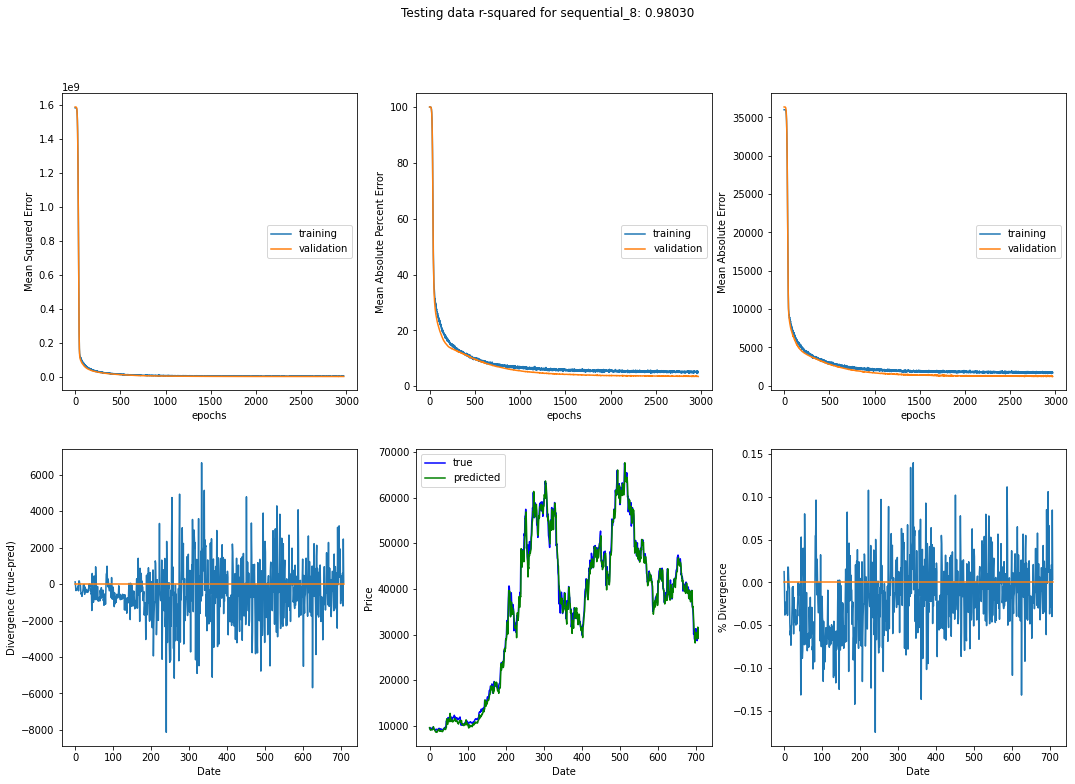

In [38]:
#show metrics for current model
fig = plt.figure('Evaluation', figsize=(18,12))
test_prediction = model.predict(features_test)
ftr = ct.fit_transform(features)
dates = coin.data.time[window+2:].reset_index(drop=True)
prediction = [p[0] for p in model.predict(ftr)]
divergence = [pred-true for true, pred in zip(labels, prediction)]
percent_divergence = [(pred-true)/true for true, pred in zip(labels, prediction)]
r2 = r2_score(test_prediction, labels_test)
fig.suptitle(f'Testing data r-squared for {model.name}: {r2:.5f}')

ax1 = fig.add_subplot(2,3,1)
ax1.plot(history.history['loss'], label='training')
ax1.plot(history.history['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.legend(loc='center right')

ax2 = fig.add_subplot(2,3,2)
ax2.plot(history.history['mape'], label='training')
ax2.plot(history.history['val_mape'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Mean Absolute Percent Error')
ax2.legend(loc='center right')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(history.history['mae'], label='training')
ax3.plot(history.history['val_mae'], label='validation')
ax3.set_xlabel('epochs')
ax3.set_ylabel('Mean Absolute Error')
ax3.legend(loc='center right')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(range(len(dates)), divergence)
ax4.plot([0 for _ in range(len(dates))])
ax4.set_xlabel('Date')
ax4.set_ylabel('Divergence (true-pred)')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(range(len(dates)), labels, label='true', color='blue')
ax5.plot(prediction, label='predicted', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price')
ax5.legend(loc='upper left')

ax6 = fig.add_subplot(2,3,6)
ax6.plot(range(len(dates)), percent_divergence)
ax6.plot([0 for _ in range(len(dates))])
ax6.set_xlabel('Date')
ax6.set_ylabel('% Divergence')

comp = [[true,f'{pred:.2f}',f'{pred-true:.2f}',f'{(pred-true)/true:.2%}'] for true, pred in zip(labels, prediction)]
comp = [['true','pred','pred-true','pred-true%']] + comp
# print(*comp)
print(prediction[-1])
print(comp[499:600])

Current r-squared: 0.98030 | Loaded r-squared: 0.98024


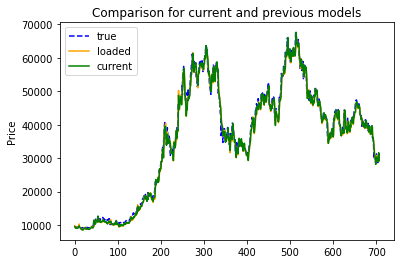

In [37]:
#compare metrics for current model vs loaded model
loaded = load_model('saves/XXBTZUSD_f12_r9802')
loaded_test_prediction = loaded.predict(features_test)
loaded_prediction = [p[0] for p in loaded.predict(ct.fit_transform(features))]
loaded_r2 = r2_score(loaded_test_prediction, labels_test)
print(f'Current r-squared: {r2:.5f} | Loaded r-squared: {loaded_r2:.5f}')
plt.plot(range(len(labels)), labels, label='true', color='blue', linestyle='--')
plt.plot(loaded_prediction, label='loaded', color='orange')
plt.plot(prediction, label='current', color='green')
plt.title('Comparison for current and previous models')
plt.legend(loc='upper left')
plt.ylabel('Price')
plt.show()

In [25]:
#save model
model.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(r2*10000)}')
# loaded.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(loaded_r2*10000)}')

INFO:tensorflow:Assets written to: saves/XXBTZUSD_f12_r9802/assets
